In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import transforms
%matplotlib inline

## Сделаем простую сверточную сеть и посмотрим какое качество она выдаст на MNIST и CIFAR10 

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root="./data", train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root="./data",train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

In [5]:
classes

('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [6]:
trainloader.dataset.train_data.shape, testloader.dataset.test_data.shape

C:\Users\timgo\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\timgo\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [7]:
trainloader.dataset.train_data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [8]:
numpy_img = trainloader.dataset.train_data[0].numpy()

In [9]:
numpy_img.shape

(28, 28)

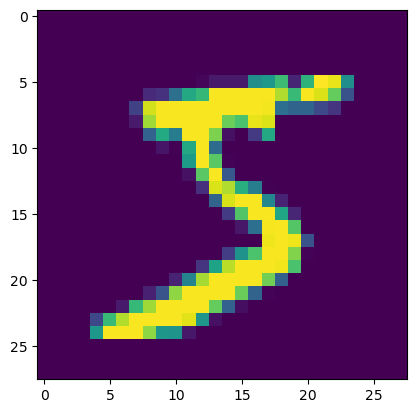

In [10]:
plt.imshow(numpy_img)

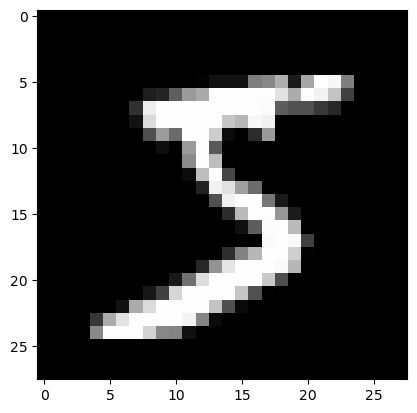

In [11]:
plt.imshow(numpy_img, cmap="gray")

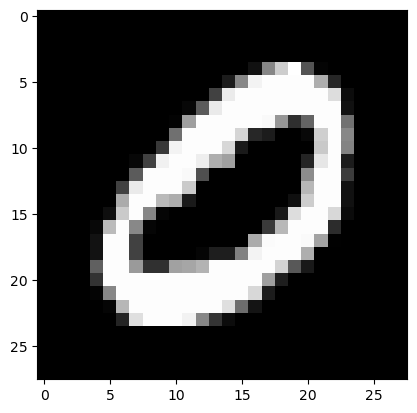

In [12]:
# случайная цифра
i = np.random.randint(0, 60000)

plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap="gray")

In [13]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходимо заранее знать, сколько каналов сейчас 1
        # картинка,которую будем передовать, и все
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape) можно использовать чтобы узнать размерность выхода последнего conv слоя
        x = x.view(-1, 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
net = SimpleConvNet()
bath = []

batch = next(iter(trainloader))

net.forward(torch.FloatTensor(batch[0]))

tensor([[ 0.0052,  0.0333, -0.1029,  0.0781, -0.1349,  0.0909,  0.0476, -0.0233,
         -0.0103, -0.0763],
        [ 0.0043,  0.0381, -0.1013,  0.0820, -0.1326,  0.0894,  0.0474, -0.0257,
         -0.0162, -0.0787],
        [ 0.0022,  0.0363, -0.1005,  0.0798, -0.1306,  0.0895,  0.0455, -0.0255,
         -0.0167, -0.0752],
        [ 0.0048,  0.0330, -0.1108,  0.0829, -0.1263,  0.0964,  0.0435, -0.0201,
         -0.0156, -0.0826]], grad_fn=<AddmmBackward0>)

In [15]:
from tqdm.notebook import tqdm

In [16]:
net = SimpleConvNet().to(device)

In [17]:
next(net.parameters()).device # как проверить что модель на gpu

device(type='cuda', index=0)

In [18]:
loss_fn = CrossEntropyLoss()

learning_rate = 1e-4
optim = torch.optim.Adam(net.parameters(), lr=learning_rate)
losses = []

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1, 2000] : 0.9691047404566779
[1, 4000] : 0.36887411207990956
[1, 6000] : 0.2912516446914815
[1, 8000] : 0.2444172233362915
[1, 10000] : 0.2149581833432603
[1, 12000] : 0.196767131506218
[1, 14000] : 0.16912192840463103


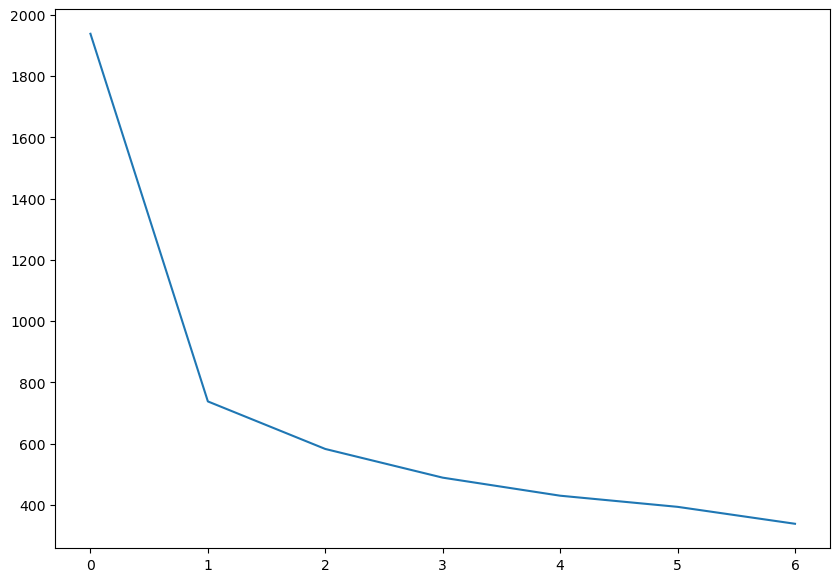

Well done solder


  0%|          | 0/15000 [00:00<?, ?it/s]

[2, 2000] : 0.14256842355494154
[2, 4000] : 0.1259718669388676
[2, 6000] : 0.11507258159027697
[2, 8000] : 0.11423630745185073
[2, 10000] : 0.10074037559911449
[2, 12000] : 0.0939147286931402
[2, 14000] : 0.0940113044924019
Well done solder


In [19]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)

for epoch in tqdm(range(2)):
    
    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        X_batch, y_batch = batch
        
        optim.zero_grad()
        
        y_pred = net(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optim.step()
        
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1}] : {running_loss / 2000}")
            losses.append(running_loss)
            running_loss = 0.0
            
            
    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

    print("Well done solder")

In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


with torch.no_grad():
    for data in testloader:
        images, labels = data

        y_pred = net(images.to(device))
        _, predicted = torch.max(y_pred, 1)

        c = predicted.cpu().detach() == labels # тк predicted на gpu а labels на cpu
        # то переносим predicted на cpu
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f"Accuracy of {classes[i]} : {100 * class_correct[i] / class_total[i]} %")

Accuracy of 0 : 99.28571428571429 %
Accuracy of 1 : 98.59030837004406 %
Accuracy of 2 : 97.28682170542636 %
Accuracy of 3 : 95.84158415841584 %
Accuracy of 4 : 97.65784114052953 %
Accuracy of 5 : 98.31838565022422 %
Accuracy of 6 : 98.12108559498957 %
Accuracy of 7 : 96.01167315175097 %
Accuracy of 8 : 96.40657084188912 %
Accuracy of 9 : 95.54013875123886 %


Задача: вывести рандом картинку из тестового сета и предсказать ее класс

class: 3


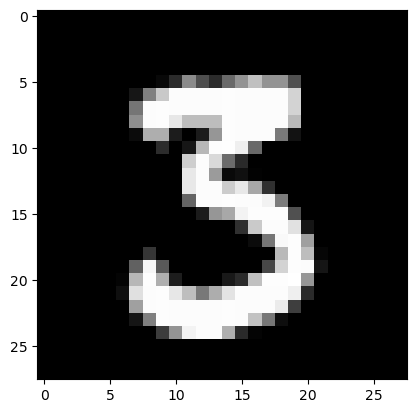

In [21]:
i = np.random.randint(0,10000)

img = testloader.dataset.test_data[i].to(torch.float32)
plt.imshow(img.numpy(), cmap="gray")

net.eval()
_, predicted = net(img.view(1,28,28).to(device)).max(1)
print(f"class: {predicted.item()}")

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                      download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [37]:
train_loader.dataset.data.shape, test_loader.dataset.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

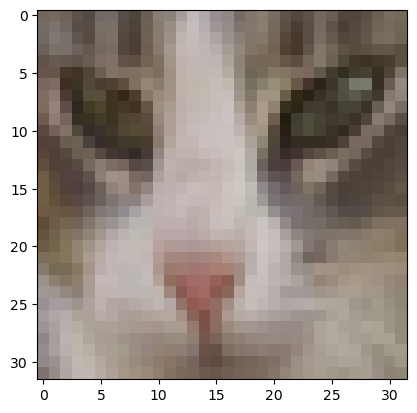

In [38]:
i = np.random.randint(1, 50000)

img = train_loader.dataset.data[i]

plt.imshow(img)

In [39]:
classes = train_loader.dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Задача сделать сеть для cifar10

In [22]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cn1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5) # просто меняем число входных каналов
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.cn2 = nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=3)
        self.fc1 = nn.Linear(128 * 6 * 6, 128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)
        
    
    def forward(self, x):
        x = self.pool(F.relu(self.cn1(x)))
        x = self.pool(F.relu(self.cn2(x)))
        #print(x.shape)
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [42]:
batch = []

batch = next(iter(train_loader))

net = MyModel()
net.forward(torch.FloatTensor(batch[0]))

tensor([[ 0.0598, -0.0969,  0.0053,  ...,  0.1143, -0.0204, -0.0660],
        [ 0.0636, -0.0903, -0.0002,  ...,  0.1165, -0.0286, -0.0640],
        [ 0.0624, -0.0888,  0.0048,  ...,  0.1138, -0.0312, -0.0662],
        ...,
        [ 0.0575, -0.0855,  0.0014,  ...,  0.1264, -0.0204, -0.0635],
        [ 0.0595, -0.0988, -0.0082,  ...,  0.1167, -0.0252, -0.0589],
        [ 0.0516, -0.0938, -0.0114,  ...,  0.1191, -0.0299, -0.0708]],
       grad_fn=<AddmmBackward0>)

In [43]:
net = MyModel().to(device)

In [44]:
loss_fn = CrossEntropyLoss()

losses = []
learning_rate = 1e-4
optim = torch.optim.Adam(net.parameters(), lr=learning_rate)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

[1, 391] : 1.8020248150886478


  0%|          | 0/391 [00:00<?, ?it/s]

[2, 391] : 1.472671556045942


  0%|          | 0/391 [00:00<?, ?it/s]

[3, 391] : 1.3625945346739592


  0%|          | 0/391 [00:00<?, ?it/s]

[4, 391] : 1.2825423709266937


  0%|          | 0/391 [00:00<?, ?it/s]

[5, 391] : 1.2179161235499565


  0%|          | 0/391 [00:00<?, ?it/s]

[6, 391] : 1.1598213837884577


  0%|          | 0/391 [00:00<?, ?it/s]

[7, 391] : 1.113378304349797


  0%|          | 0/391 [00:00<?, ?it/s]

[8, 391] : 1.0716092548406948


  0%|          | 0/391 [00:00<?, ?it/s]

[9, 391] : 1.0344835219480801


  0%|          | 0/391 [00:00<?, ?it/s]

[10, 391] : 0.9986351780269457
WELL DONE SOLDER


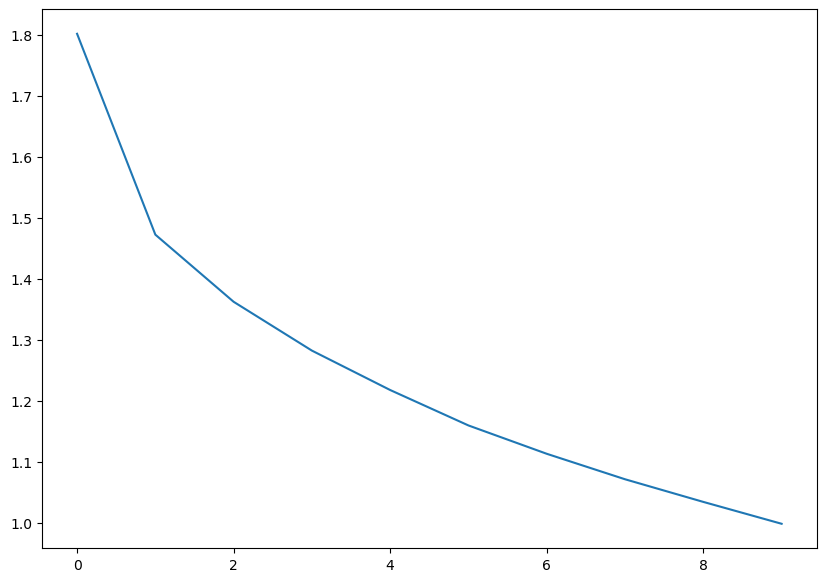

In [45]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)

for epoch in tqdm(range(10)):
    running_loss = 0.0
    for i, batch in enumerate(tqdm(train_loader)):
        X_batch, y_batch = batch
        
        optim.zero_grad()
        
        y_pred = net(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        
        loss.backward()
        optim.step()
        
        running_loss += loss.item()
        
        if i % 391 == 390:
            print(f"[{epoch + 1}, {i + 1}] : {running_loss / 391}")
            losses.append(running_loss / 391)
            running_loss = 0.0
    

plt.plot(np.arange(len(losses)), losses)
print("WELL DONE SOLDER")
        

In [46]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [47]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


with torch.no_grad():
    for data in test_loader:
        images, labels = data

        y_pred = net(images.to(device))
        _, predicted = torch.max(y_pred, 1)

        c = predicted.cpu().detach() == labels # тк predicted на gpu а labels на cpu
        # то переносим predicted на cpu
        if len(labels) == 128:
            for i in range(128):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
        else:
            for i in range(16):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            

for i in range(10):
    print(f"Accuracy of {classes[i]} : {100 * class_correct[i] / class_total[i]} %")

Accuracy of airplane : 77.0 %
Accuracy of automobile : 76.7 %
Accuracy of bird : 50.2 %
Accuracy of cat : 51.3 %
Accuracy of deer : 51.6 %
Accuracy of dog : 51.5 %
Accuracy of frog : 77.3 %
Accuracy of horse : 72.6 %
Accuracy of ship : 75.0 %
Accuracy of truck : 59.4 %
